## Imports

In [1]:
import numpy as np
import keras
import matplotlib.pyplot as plt
import keras.utils as np_utils
# Import optimizer
from keras.optimizers import SGD
# Import data
from keras.datasets import cifar100
# Import models and layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

Using TensorFlow backend.


## Auxiliar functions

Configures the model.
Args:
+ ```optimizer:``` Optimizer function.
+ ```loss:``` Loss function.
+ ```metrics:``` Metric function.

In [2]:
def compile(model, loss, optimizer, metrics):
    model.compile(loss = loss,
                  optimizer = optimizer,
                  metrics = metrics)

Trains the given model.

args:
+ ```model:``` Model to train.
+ ```batch_size:```
+ ```epochs:``` 
+ ```data:``` Given by ```x_train```, ```x_test```, ```y_train``` and ```y_test```

In [3]:
def train(model, batch_size, epochs, x_train, y_train, x_test, y_test):
    history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
    return history

Shows model results in test partition.

In [4]:
def results(model, x_test, y_test):
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss: ', score[0])
    print('Test accuracy: ', score[1])

Calculates model accuracy.

In [5]:
def calAccuracy(labels, preds):
    labels = np.argmax(labels, axis = 1)
    preds = np.argmas(preds, axis = 1)
    
    return sum(labels==preds)/len(labels)

Esta función pinta dos gráficas
+ La evolución de la función de pérdida en el conjunto de train y en el de validación.
+ La evolución del accuracy en el conjunto de train y el de validación.

Parmámetros
+ ```hist```: Historial del entrenamiento del modelo

In [11]:
def showEvolution(hist):
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['Training loss', 'Validation loss'])
    plt.show()
    
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    plt.plot(acc)
    plt.plot(val_acc)
    plt.legend(['Training accuracy', 'Validation accuracy'])

# Exercise 1

## Load Data.

In [7]:
def loadCifrarData():
    # Load Data
    (x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

    # Transform to float and normalize
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255
    
    # We will use only 25 classes.
    train_idx = np.isin(y_train, np.arange(25))
    train_idx = np.reshape(train_idx, -1)
    x_train = x_train[train_idx]
    y_train = y_train[train_idx]
    test_idx = np.isin(y_test, np.arange(25))
    test_idx = np.reshape(test_idx, -1)
    x_test = x_test[test_idx]
    y_test = y_test[test_idx]
    
    # Pass variables to cathegorical
    y_train = np_utils.to_categorical(y_train, 25)
    y_test = np_utils.to_categorical(y_test, 25)
    
    return x_train, y_train, x_test, y_test

## Model Definition

In [8]:
def baseNetModel():
    model = Sequential()
    model.name = 'BaseNet Model'
    model.add(Conv2D(6, kernel_size=(5, 5),
                     activation='relu',
                     input_shape=(32,32,3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(16, kernel_size=(5,5), 
                    activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(25, activation='softmax'))
    
    return model

## Model train and test

In [9]:
def ej1():
    model = baseNetModel()
    model.summary()
    compile(model,
        keras.losses.categorical_crossentropy,
        SGD(lr = 0.01, decay = 1e-6, momentum=0.9, nesterov=True),
        ['accuracy'])
    data = loadCifrarData()
    history = train(model, 128,
          10,
          *data)
    results(model, *data[:2])
    showEvolution(history)

# Main function

Model: "BaseNet Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 6)         456       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                20050     
_________________________________________________________________
dense_4 (Dense)              (None, 25)              

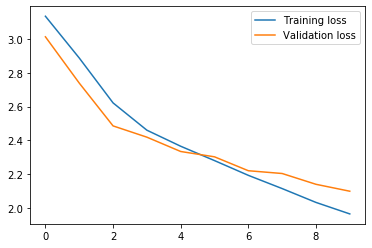

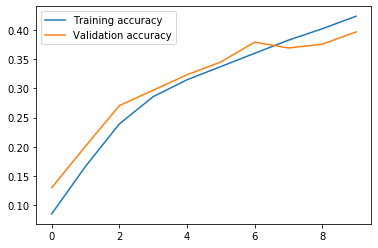

In [12]:
def main():
    ej1()
    
main()